In [3]:
# Advanced Portfolio Optimizer (011_advanced_model.ipynb)
# Part 1: Setup & Imports

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from arch import arch_model  # for volatility modeling
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from sklearn.covariance import LedoitWolf

# Optional: For forecasting + ML
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit

# Optional: For CVaR optimization
import cvxpy as cp

# Download and preprocess historical data
TICKERS =  [
    "SCHD", "SWPPX", "SCHG", "QQQM", "PLTR", "MSTR", "SOFI", "MSFT", "BRK-B", "GOOG", "JPM", "MRK", "LULU", "UNH",
    "QQQ", "VTI", "SPY", "IVV", "DIA", "IWM", "VT", "VOO", "SPLG", "RSP",
    "XLF", "XLK", "XLY", "XLP", "XLV", "XLE", "XLU", "XLI", "XLB", "VNQ",
    "AAPL", "NVDA", "AMD", "META", "TSLA", "AMZN", "CRM", "GOOGL", "ORCL", "AVGO",
    "ADBE", "SNOW", "SHOP", "INTU", "PANW", "ZS", "NET", "COIN", "DOCU",
    "BAC", "WFC", "GS", "MS", "C", "TFC", "USB", "SCHW", "PGR", "CBRE",
    "BA", "CAT", "DE", "HON", "GE", "NOC", "RTX", "XOM", "CVX", "FCX",
    "PFE", "JNJ", "ABBV", "LLY", "BMY", "ZBH", "ISRG", "TMO", "MDT", "GILD",
    "WMT", "COST", "HD", "LOW", "TGT", "SBUX", "MCD", "KO", "PEP", "NKE"
]

data = yf.download(TICKERS, start="2010-01-01", end="2025-04-30", group_by="ticker", auto_adjust=True)
prices = pd.concat([data[ticker]["Close"] for ticker in TICKERS], axis=1)
prices.columns = TICKERS
returns = prices.pct_change().dropna()

# Save for next steps
returns.to_csv("../data/processed/advanced_returns.csv")
print("✅ Base data prepared.")


[*********************100%***********************]  93 of 93 completed


✅ Base data prepared.


⏳ Fitting Markov Switching model...


c:\Users\chris\OneDrive\Desktop\PortfolioOptimization_V0.1\venv310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\chris\AppData\Local\Temp\ipykernel_22580\3397265530.py:19: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\chris\OneDrive\Desktop\PortfolioOptimization_V0.1\venv310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


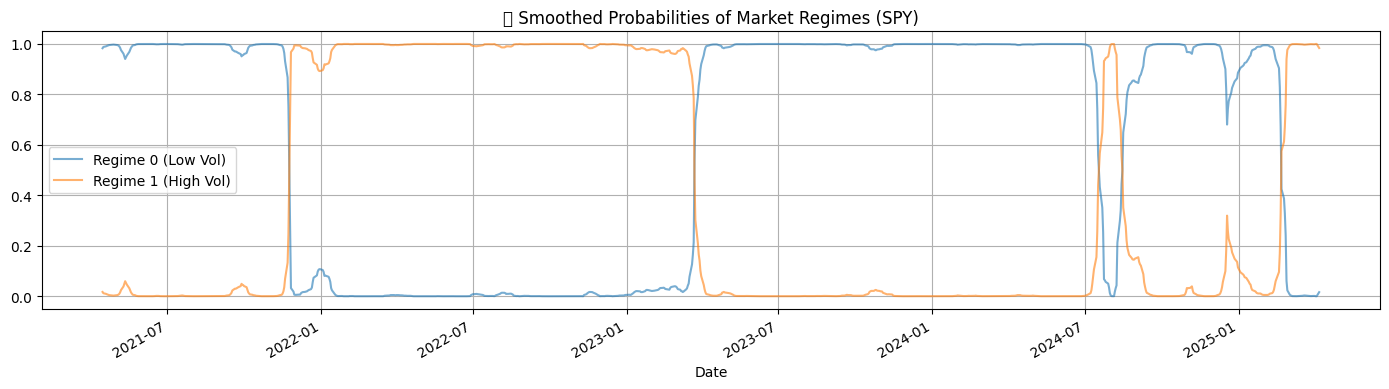

✅ Regime analysis complete. Assigned to 'returns["Regime"]'


In [4]:
# === Part 2: Regime Switching Risk Model ===
spy_returns = returns["SPY"] * 100  # Percent scale for model

# Fit 2-regime model: mean and variance vary by regime
print("⏳ Fitting Markov Switching model...")
model = MarkovRegression(spy_returns, k_regimes=2, trend='c', switching_variance=True)
res = model.fit(disp=False)

# Extract smoothed regime probabilities
regimes = res.smoothed_marginal_probabilities

# Plot regime probabilities
plt.figure(figsize=(14, 4))
regimes[0].plot(label="Regime 0 (Low Vol)", alpha=0.6)
regimes[1].plot(label="Regime 1 (High Vol)", alpha=0.6)
plt.title("🌀 Smoothed Probabilities of Market Regimes (SPY)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Tag each day with the most likely regime
most_likely = regimes.idxmax(axis=1)
returns["Regime"] = most_likely

print("✅ Regime analysis complete. Assigned to 'returns[\"Regime\"]'")


[*********************100%***********************]  77 of 77 completed


✅ Base data prepared.
⚙️ Running relaxed CVaR optimization (no MIP)...


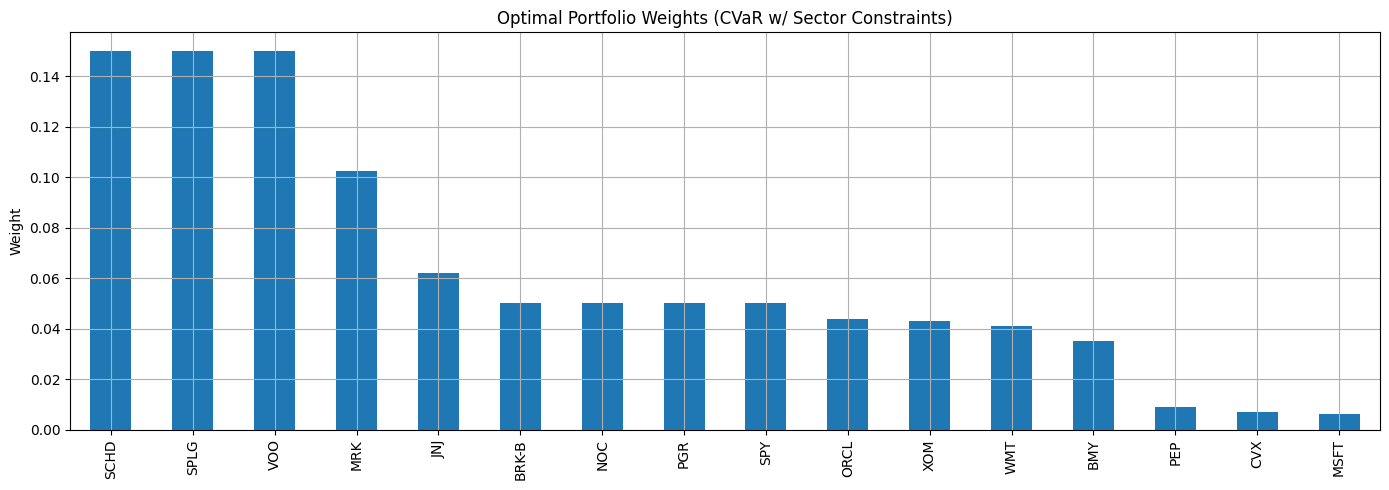

✅ CVaR optimization complete with sector constraints.


In [12]:
# Advanced Portfolio Optimizer (011_advanced_model.ipynb)
# Part 1: Setup & Imports

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from arch import arch_model  # for volatility modeling
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from sklearn.covariance import LedoitWolf

# Optional: For forecasting + ML
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit

# Optional: For CVaR optimization
import cvxpy as cp

# Define ETFs only
ETF_TICKERS = [
    "SCHD", "SWPPX", "SCHG", "QQQM", "VTI", "SPY", "VOO", "SPLG"
]

# Organized by sector (non-ETF)
TECH_AI = ["MSFT", "GOOG", "GOOGL", "AAPL", "NVDA", "AMD", "META", "TSLA", "AMZN", "CRM", "ORCL", "AVGO", "ADBE", "SNOW", "SHOP", "INTU", "PANW", "ZS", "NET", "COIN", "DOCU"]
FINANCIALS = ["JPM", "BAC", "WFC", "GS", "MS", "C", "TFC", "USB", "SCHW", "PGR"]
INDUSTRIALS = ["BA", "CAT", "DE", "HON", "GE", "NOC", "RTX", "CBRE"]
ENERGY = ["XOM", "CVX", "FCX"]
HEALTHCARE = ["PFE", "JNJ", "ABBV", "LLY", "BMY", "ZBH", "ISRG", "TMO", "MDT", "GILD", "UNH", "MRK"]
CONSUMER = ["WMT", "COST", "HD", "LOW", "TGT", "SBUX", "MCD", "KO", "PEP", "NKE", "LULU"]
MISC = ["PLTR", "MSTR", "SOFI", "BRK-B"]

TICKERS = ETF_TICKERS + TECH_AI + FINANCIALS + INDUSTRIALS + ENERGY + HEALTHCARE + CONSUMER + MISC

# Download data
data = yf.download(TICKERS, start="2010-01-01", end="2025-04-30", group_by="ticker", auto_adjust=True)
prices = pd.concat([data[ticker]["Close"] for ticker in TICKERS], axis=1)
prices.columns = TICKERS
returns = prices.pct_change().dropna()

# Save
returns.to_csv("../data/processed/advanced_returns.csv")
print("✅ Base data prepared.")

# === Part 3: CVaR Optimization (no binary) with sector constraints ===
print("⚙️ Running relaxed CVaR optimization (no MIP)...")

assets = returns.columns
n = len(assets)
alpha = 0.95

# Variables
w = cp.Variable(n)
z = cp.Variable(returns.shape[0])
VaR = cp.Variable()
losses = -returns.values @ w
cvar = VaR + (1 / ((1 - alpha) * returns.shape[0])) * cp.sum(z)
objective = cp.Minimize(cvar)

# Sector masks
sector_masks = {
    "ETF": [1 if t in ETF_TICKERS else 0 for t in assets],
    "TECH_AI": [1 if t in TECH_AI else 0 for t in assets],
    "FIN": [1 if t in FINANCIALS else 0 for t in assets],
    "IND": [1 if t in INDUSTRIALS else 0 for t in assets],
    "ENE": [1 if t in ENERGY else 0 for t in assets],
    "HEA": [1 if t in HEALTHCARE else 0 for t in assets],
    "CON": [1 if t in CONSUMER else 0 for t in assets],
    "MISC": [1 if t in MISC else 0 for t in assets]
}

# Constraints
constraints = [
    cp.sum(w) == 1,
    w >= 0,
    w <= 0.15,
    cp.sum(cp.multiply(sector_masks["ETF"], w)) >= 0.5,  # 50% ETF minimum
    cp.sum(cp.multiply(sector_masks["TECH_AI"], w)) >= 0.05,
    cp.sum(cp.multiply(sector_masks["FIN"], w)) >= 0.05,
    cp.sum(cp.multiply(sector_masks["IND"], w)) >= 0.05,
    cp.sum(cp.multiply(sector_masks["ENE"], w)) >= 0.05,
    cp.sum(cp.multiply(sector_masks["HEA"], w)) >= 0.05,
    cp.sum(cp.multiply(sector_masks["CON"], w)) >= 0.05,
    cp.sum(cp.multiply(sector_masks["MISC"], w)) >= 0.05,
    z >= 0,
    z >= losses - VaR
]

# Solve
problem = cp.Problem(objective, constraints)
problem.solve()

# Format weights
cvar_weights = pd.Series(w.value, index=assets)
cvar_weights = cvar_weights[cvar_weights > 0.005].sort_values(ascending=False)

# Plot
cvar_weights.plot(kind='bar', figsize=(14, 5), title="Optimal Portfolio Weights (CVaR w/ Sector Constraints)")
plt.ylabel("Weight")
plt.grid(True)
plt.tight_layout()
plt.show()

print("✅ CVaR optimization complete with sector constraints.")


[*********************100%***********************]  77 of 77 completed


✅ Base data prepared.
⚙️ Running relaxed CVaR optimization (no MIP)...


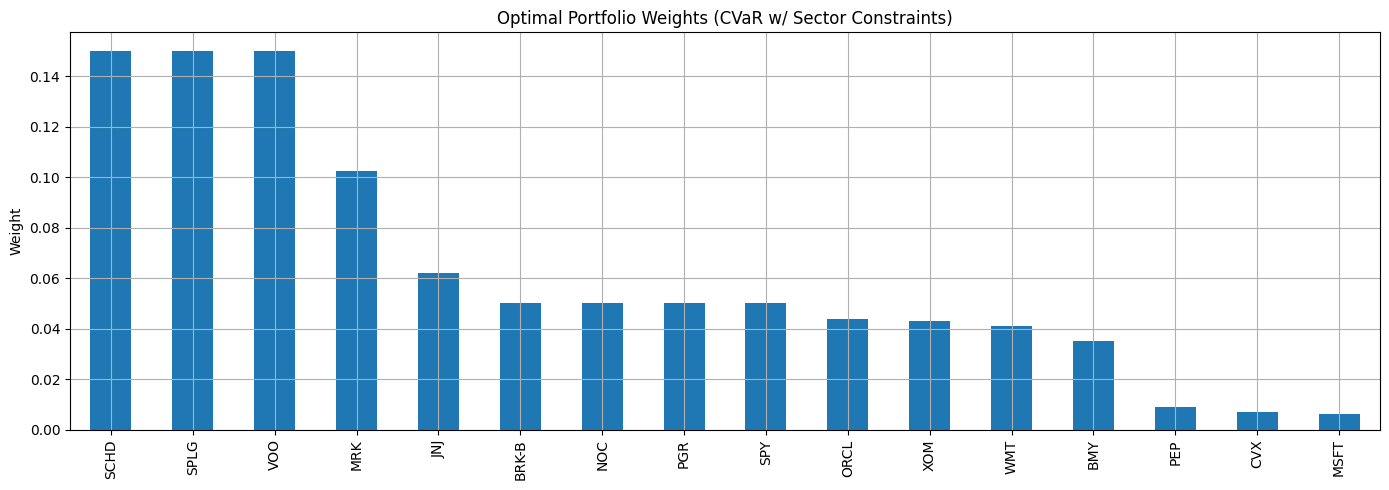

✅ CVaR optimization complete with sector constraints.
📈 Backtesting vs SPY...


C:\Users\chris\AppData\Local\Temp\ipykernel_22580\2211816391.py:123: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\chris\OneDrive\Desktop\PortfolioOptimization_V0.1\venv310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


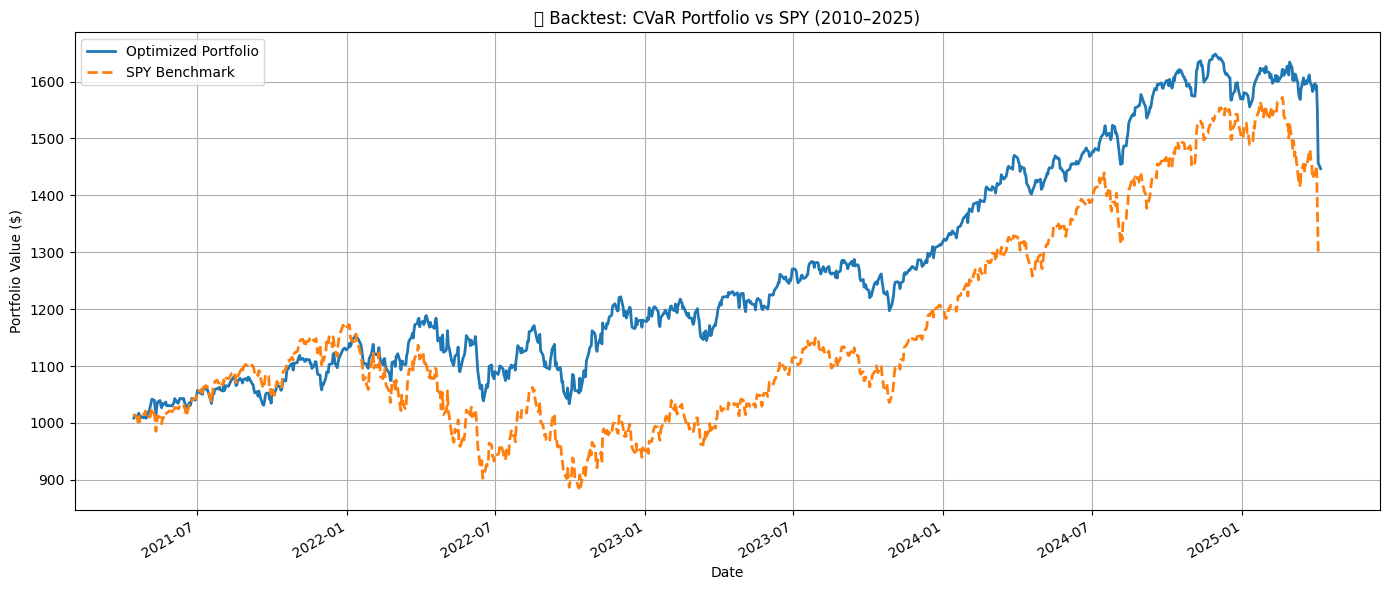

🔮 Forecasting future (2025–2030) with GBM...


C:\Users\chris\AppData\Local\Temp\ipykernel_22580\2211816391.py:165: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\chris\OneDrive\Desktop\PortfolioOptimization_V0.1\venv310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


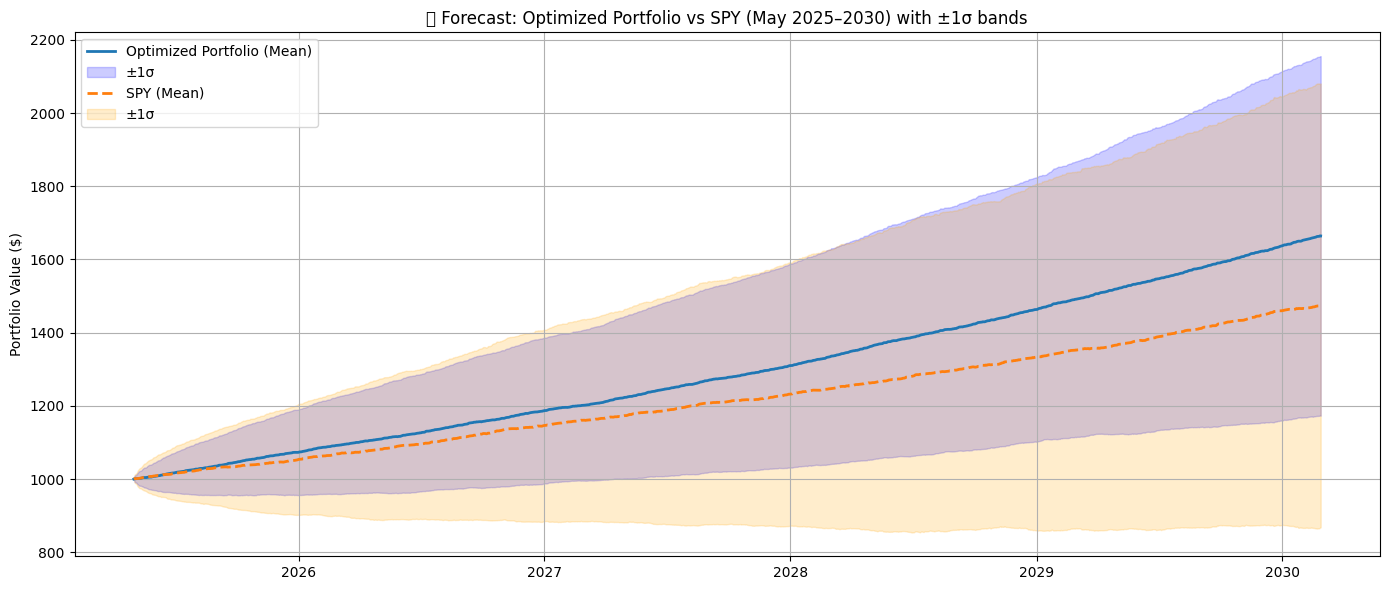

In [14]:
# Advanced Portfolio Optimizer (011_advanced_model.ipynb)
# Part 1: Setup & Imports

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from arch import arch_model  # for volatility modeling
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from sklearn.covariance import LedoitWolf

# Optional: For forecasting + ML
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit

# Optional: For CVaR optimization
import cvxpy as cp

# Define ETFs only
ETF_TICKERS = [
    "SCHD", "SWPPX", "SCHG", "QQQM", "VTI", "SPY", "VOO", "SPLG"
]

# Organized by sector (non-ETF)
TECH_AI = ["MSFT", "GOOG", "GOOGL", "AAPL", "NVDA", "AMD", "META", "TSLA", "AMZN", "CRM", "ORCL", "AVGO", "ADBE", "SNOW", "SHOP", "INTU", "PANW", "ZS", "NET", "COIN", "DOCU"]
FINANCIALS = ["JPM", "BAC", "WFC", "GS", "MS", "C", "TFC", "USB", "SCHW", "PGR"]
INDUSTRIALS = ["BA", "CAT", "DE", "HON", "GE", "NOC", "RTX", "CBRE"]
ENERGY = ["XOM", "CVX", "FCX"]
HEALTHCARE = ["PFE", "JNJ", "ABBV", "LLY", "BMY", "ZBH", "ISRG", "TMO", "MDT", "GILD", "UNH", "MRK"]
CONSUMER = ["WMT", "COST", "HD", "LOW", "TGT", "SBUX", "MCD", "KO", "PEP", "NKE", "LULU"]
MISC = ["PLTR", "MSTR", "SOFI", "BRK-B"]

TICKERS = ETF_TICKERS + TECH_AI + FINANCIALS + INDUSTRIALS + ENERGY + HEALTHCARE + CONSUMER + MISC

# Download data
data = yf.download(TICKERS + ["SPY"], start="2010-01-01", end="2025-04-30", group_by="ticker", auto_adjust=True)
prices = pd.concat([data[ticker]["Close"] for ticker in TICKERS], axis=1)
prices.columns = TICKERS
returns = prices.pct_change().dropna()

# Save
returns.to_csv("../data/processed/advanced_returns.csv")
print("✅ Base data prepared.")

# === Part 3: CVaR Optimization (no binary) with sector constraints ===
print("⚙️ Running relaxed CVaR optimization (no MIP)...")

assets = returns.columns
n = len(assets)
alpha = 0.95

# Variables
w = cp.Variable(n)
z = cp.Variable(returns.shape[0])
VaR = cp.Variable()
losses = -returns.values @ w
cvar = VaR + (1 / ((1 - alpha) * returns.shape[0])) * cp.sum(z)
objective = cp.Minimize(cvar)

# Sector masks
sector_masks = {
    "ETF": [1 if t in ETF_TICKERS else 0 for t in assets],
    "TECH_AI": [1 if t in TECH_AI else 0 for t in assets],
    "FIN": [1 if t in FINANCIALS else 0 for t in assets],
    "IND": [1 if t in INDUSTRIALS else 0 for t in assets],
    "ENE": [1 if t in ENERGY else 0 for t in assets],
    "HEA": [1 if t in HEALTHCARE else 0 for t in assets],
    "CON": [1 if t in CONSUMER else 0 for t in assets],
    "MISC": [1 if t in MISC else 0 for t in assets]
}

# Constraints
constraints = [
    cp.sum(w) == 1,
    w >= 0,
    w <= 0.15,
    cp.sum(cp.multiply(sector_masks["ETF"], w)) >= 0.5,  # 50% ETF minimum
    cp.sum(cp.multiply(sector_masks["TECH_AI"], w)) >= 0.05,
    cp.sum(cp.multiply(sector_masks["FIN"], w)) >= 0.05,
    cp.sum(cp.multiply(sector_masks["IND"], w)) >= 0.05,
    cp.sum(cp.multiply(sector_masks["ENE"], w)) >= 0.05,
    cp.sum(cp.multiply(sector_masks["HEA"], w)) >= 0.05,
    cp.sum(cp.multiply(sector_masks["CON"], w)) >= 0.05,
    cp.sum(cp.multiply(sector_masks["MISC"], w)) >= 0.05,
    z >= 0,
    z >= losses - VaR
]

# Solve
problem = cp.Problem(objective, constraints)
problem.solve()

# Format weights
cvar_weights = pd.Series(w.value, index=assets)
cvar_weights = cvar_weights[cvar_weights > 0.005].sort_values(ascending=False)

# Plot weights
cvar_weights.plot(kind='bar', figsize=(14, 5), title="Optimal Portfolio Weights (CVaR w/ Sector Constraints)")
plt.ylabel("Weight")
plt.grid(True)
plt.tight_layout()
plt.show()

print("✅ CVaR optimization complete with sector constraints.")

# === Backtest vs SPY ===
print("📈 Backtesting vs SPY...")
opt_portfolio_returns = (returns[cvar_weights.index] @ cvar_weights).dropna()
spy_returns = data['SPY']['Close'].pct_change().reindex(opt_portfolio_returns.index).dropna()

initial_value = 1000
opt_value = (1 + opt_portfolio_returns).cumprod() * initial_value
spy_value = (1 + spy_returns).cumprod() * initial_value

plt.figure(figsize=(14, 6))
opt_value.plot(label="Optimized Portfolio", linewidth=2)
spy_value.plot(label="SPY Benchmark", linestyle="--", linewidth=2)
plt.title("📊 Backtest: CVaR Portfolio vs SPY (2010–2025)")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Forecast with GBM ===
print("🔮 Forecasting future (2025–2030) with GBM...")
import datetime as dt

sim_days = 252 * 5
n_sim = 1000  # more paths

mu_opt = opt_portfolio_returns.mean()
sigma_opt = opt_portfolio_returns.std()
mu_spy = spy_returns.mean()
sigma_spy = spy_returns.std()

opt_sim = np.zeros((sim_days, n_sim))
spy_sim = np.zeros((sim_days, n_sim))
opt_sim[0] = 1000  # restart from $1000 in April 2025
spy_sim[0] = 1000

np.random.seed(42)
for t in range(1, sim_days):
    opt_sim[t] = opt_sim[t - 1] * np.exp((mu_opt - 0.5 * sigma_opt**2) + sigma_opt * np.random.normal(0, 1, n_sim))
    spy_sim[t] = spy_sim[t - 1] * np.exp((mu_spy - 0.5 * sigma_spy**2) + sigma_spy * np.random.normal(0, 1, n_sim))

forecast_index = pd.date_range(start=pd.to_datetime("2025-05-01"), periods=sim_days, freq="B")

# Plot with mean + std bands
opt_mean = opt_sim.mean(axis=1)
opt_std = opt_sim.std(axis=1)
spy_mean = spy_sim.mean(axis=1)
spy_std = spy_sim.std(axis=1)

plt.figure(figsize=(14, 6))
plt.plot(forecast_index, opt_mean, label="Optimized Portfolio (Mean)", linewidth=2)
plt.fill_between(forecast_index, opt_mean - opt_std, opt_mean + opt_std, color="blue", alpha=0.2, label="±1σ")
plt.plot(forecast_index, spy_mean, label="SPY (Mean)", linestyle="--", linewidth=2)
plt.fill_between(forecast_index, spy_mean - spy_std, spy_mean + spy_std, color="orange", alpha=0.2, label="±1σ")
plt.title("🔮 Forecast: Optimized Portfolio vs SPY (May 2025–2030) with ±1σ bands")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()